In [16]:
#ete kernel
import pandas as pd
import matplotlib.pyplot as plt
import difflib
import os
import re
from ete3 import ClusterTree, TreeStyle, ProfileFace
from ete3.treeview.faces import add_face_to_node
import numpy as np

import loess
from loess import loess_1d
from collections import defaultdict 

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/Evolution_stuff/activity_heatmaps/")

# Prepare Data

In [17]:
# Load the file with the length of overlap between orthologs and tile data

# Dataframe with rows as the gnc4 orthologs and columns as the tiles with experimental data
# The values is the longest subsequence that overlaps between row tile/orthologs

data_df = pd.read_csv("hmmer_experimental_overlap.csv") 
data_df.index = data_df["hmmer_sequence"]
data_df = data_df.drop_duplicates()
data_df

,hmmer_sequence,LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL,DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL,VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG,NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL,QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ,SSTTALQQQHRQTRPQVPLFSQSTGSIPKTPNMVMQGTYI,KGGKLQASKEALYLGNAGTASRFLTTVVALCSPSDVSSTV,LHNITMDHGKERNDCRPDEANGSHSGSCLPISSTPREQWR,IAGATSKEPMLSLNEDNENNDDDADDADDDDDALVPREDT,...,NTEMDLNAAPEEWESLFPQDGFPLDLDSAALELAVSLQQP,SVNSLPEDFVLFPAAPCPQPRLRDSRTPVLPSATPRSASY,SSSAAALQNQRVAAIIQSTGHSINTSALTNRFTPQQSSIQ,GVGSRRRDKPLPPIIVEDPSDVVAMKRARNTLAARKSRER,CSPGSPVPSIESPSFIFYNNTAITSYLKSPDFRSHRIATP,VDDPTDTVAMKRARNTLAARKSRERKAQRFEELEERIRKL,RRHSSNLPSASSLQNQRVAAIIQSTGHSISTSALTNRFNP,VLPSATPRSASYHPYLVQSQYQPRRHSLSLYQHLQQQKLA,DLPDLFDLHADRFGDDLIPTTESTMLSPQQMTAGVMAGPD,YSSPAMPNLFDMSGASSSSTNLGTVSPQDLLIQEPFMSAP
hmmer_sequence,,,,,,,,,,,,,,,,,,,,,
MLQFSNQNMSTFTATKATSSATITNNNQLNNNNNTNTSNTTKINNKLKKIINKKIMTSLNNTNNINAVNNLMIPMDLGLFNSNPTTSNTGSNSTDIKLEDTPLFSFANLPNLISNQDQVSTTTTANNTTNNTPWIGYEDIDSATVDAFFSSSTDSTPLFEFETLNKTSNSNAVQGKDASSSDPIANSASHEWTSLFDNDIPVSSADVDLASKAIELIEQDPQFIKDTTTNTSTSIPTSFTATFPSLDNQFSNTSGSSNSRTVNGTTRIISADSFLPTPIMENAKLSTISSASHASKIVKGEKIDHLGIISYNRKQRQAPLKPVVAESNDPVAMKRARNTEAARRSRARKLQRMNQLEDKVEDLLTRNSQLEMEVARLQSLLNNGK,MLQFSNQNMSTFTATKATSSATITNNNQLNNNNNTNTSNTTKINNK...,3,4,3,3,4,4,3,3,3,...,3,3,3,9,3,9,3,3,3,4
MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLVFDKFIKTEEDPMIKQDAPTNLDFDFALPQTATASNAETALPISELDAAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIESTEEASLVPSNLEVSTTSFLPTPILEDAKLSQTKRAKKPNSIVKKSHHHHHHHHDDDEDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEQLLSKNYHLENEVERLKKLVGEN,MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLV...,3,3,3,3,3,3,3,4,3,...,3,3,3,6,3,6,3,3,3,4
MSTINNNIHHQQSIFDITSFEPQMSMEFMPSASTTAEQQEAVNYRKPIMGELVFDKFIQKDTIDGPLVKTEESTPLLNFDLQLAVDTARSSEQLNSAVVDTFFSSSTDSSPMFEFENLESDPKSWGSLFDNDIPVTVNDASLATSAIEVPTEDSTAPSPVIAASNVEKKSFLPTPVIEDAKLPIVGKKSFSSNKKSGAVDKSEKYDHLGVISYNRKSRSNPLTPIIPESDDPAAMKRARNTEAARRSRARKLQRMNQLELKVEELLKRNTELEDEVTRLRSLLGSQ,MSTINNNIHHQQSIFDITSFEPQMSMEFMPSASTTAEQQEAVNYRK...,3,3,3,3,3,4,3,3,3,...,3,3,3,8,3,8,4,3,3,4
MSEYQPSLFALNPMGFSPLDGSKPTNENTSTSTSSSIAKPVVGQLIFDKFIKAEEDPMIKQDAPSNLDFDFTLPQTATASNTETALPISELDAAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTSDDVLSADKAIESTEEASLVPSNLEVSTTSFLPTPILEDAKLSQTKRAKKPNSIVKKSHHHHHHHHDEDEDDEESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEQLLSKNYQLENEVERLKKLVGEN,MSEYQPSLFALNPMGFSPLDGSKPTNENTSTSTSSSIAKPVVGQLI...,3,3,3,3,3,3,3,4,3,...,3,3,3,6,3,6,3,3,3,4
MSEYQRSLFALNPMGFSPLDGSKPTNESTSASTTTAKPVVGQLVFDKFIKTEEDSMIKQDAPSNLDFDFTLPQTVTASNTEAVLPIPELDAAVVESFFSSSTDSTPMFEYENLEENSKEWTSLFDNDIPVTTDDVSLADKAIESTEEASLVPFNLEVSTISFLPTPVLEDAKLSQTKKAKKPNSIAKNFHQHHGNDDESRLDHLGVVAYNRKQRSIPLSPIVPESGDPAALKRARNTEAARRSRARKLQRMKQLEDKVEELLSKNYHLENEVARLKKLVGES,MSEYQRSLFALNPMGFSPLDGSKPTNESTSASTTTAKPVVGQLVFD...,3,3,3,3,3,3,3,3,3,...,3,4,3,6,3,6,4,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MSAAIPMSIKEDSCVESEMFQIEQDIIPKTTTEMDKKQDVSPFQIHSSVLDSVFSNNLDDATAIIDHTPMFDELDFILDGAKVNSKDDWVALFGDDEKSQADFAGPLIDLDDEVVPRDENFEGLLIETSPNGLSDDTISQSTTSVSSPSLSCAGTSITSVTNGSFNKYKNNQLATPTITPLLDVKCGSKRKRQDLKPIELDATADEALLKRAKNTLAARRSRQKKLDKMNLLEEKNNQLLDENQKLKLLLAAHNIDF,MSAAIPMSIKEDSCVESEMFQIEQDIIPKTTTEMDKKQDVSPFQIH...,2,3,4,3,3,4,3,3,3,...,4,3,3,6,3,6,3,3,4,3
MSAAMLKSTKEESYVESELFQIEQDIIPETATVNEMDKNQEVSPFQIHSSVLDSVFSNNLDDANAIVDHTPMFDELDFILDGAKVNSKDDWVALFGDDEKSQAADLAGPLIDLDDDVVPKDDKLECLFIEASPNGLTDDTISQSTTSGSSPAMSCVGTSITSVTNSSFNKYKNNQLATPTITPLLDVKSGSKRKRQELKEIDLSENTDEALLKRAKNTLAARRSRQKKLDKMNTLEQRNKELLDENQKLKLLLAAHNIDF,MSAAMLKSTKEESYVESELFQIEQDIIPETATVNEMDKNQEVSPFQ...,2,3,4,3,3,4,3,3,3,...,3,3,3,6,3,6,3,3,4,5
MSAAVPTKTIDFTLESEMIQDVKNVAPTPSVMEKNEVVSPFQIHSSVLDSVFSTNLDDPTSIVDHTPMFDELDFILDGAKVNSKDDWVALFGDEESNQLAGPLIDLDDEMVPRDENLESLFIEPSPNGLTDDTISQSTTSASSPSLSCAGTSVTSVTTMNKGKNNQLATPTITPLLDVKSGSKRKRELKPIELNDEADAVLVKRAKNTLAARRSRQKKLDKMFQLETQVDHLSAENKRLQAILASHNIDF,MSAAVPTKTIDFTLESEMIQDVKNVAPTPSVMEKNEVVSPFQIHSS...,2,3,4,3,3,4,3,3,3,...,4,3,3,6,3,6,4,3,3,4


In [18]:
# Sum the number of tiles that fully overlap with the ortholog sequence
num_tile_overlaps = (data_df == 40).sum(axis=1)
num_tile_overlaps

hmmer_sequence
MLQFSNQNMSTFTATKATSSATITNNNQLNNNNNTNTSNTTKINNKLKKIINKKIMTSLNNTNNINAVNNLMIPMDLGLFNSNPTTSNTGSNSTDIKLEDTPLFSFANLPNLISNQDQVSTTTTANNTTNNTPWIGYEDIDSATVDAFFSSSTDSTPLFEFETLNKTSNSNAVQGKDASSSDPIANSASHEWTSLFDNDIPVSSADVDLASKAIELIEQDPQFIKDTTTNTSTSIPTSFTATFPSLDNQFSNTSGSSNSRTVNGTTRIISADSFLPTPIMENAKLSTISSASHASKIVKGEKIDHLGIISYNRKQRQAPLKPVVAESNDPVAMKRARNTEAARRSRARKLQRMNQLEDKVEDLLTRNSQLEMEVARLQSLLNNGK    47
MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLVFDKFIKTEEDPMIKQDAPTNLDFDFALPQTATASNAETALPISELDAAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIESTEEASLVPSNLEVSTTSFLPTPILEDAKLSQTKRAKKPNSIVKKSHHHHHHHHDDDEDDESRLDHLGVVAYNRKQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRMKQLEDKVEQLLSKNYHLENEVERLKKLVGEN                                                                                                   49
MSTINNNIHHQQSIFDITSFEPQMSMEFMPSASTTAEQQEAVNYRKPIMGELVFDKFIQKDTIDGPLVKTEESTPLLNFDLQLAVDTARSSEQLNSAVVDTFFSSSTDSSPMFEFENLESDPKSWGSLFDNDIPVTVNDASLATSAIEVPTEDSTAPSPVIAASNVEKKSFLPTPVIEDAKLPIVGKKSFSSNKKSGAVDK

Text(0.5, 0, 'Number of tiles that overlap with sequence')

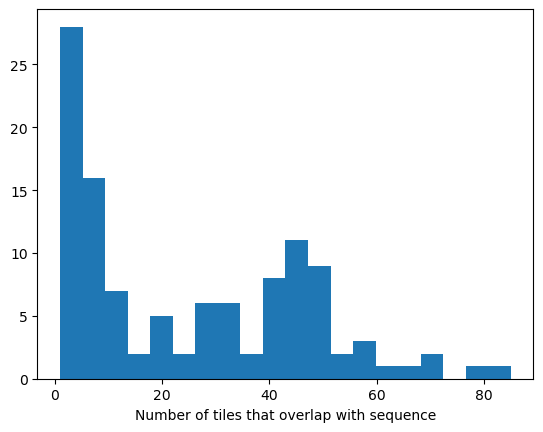

In [19]:
# Get the sequences that overlap with more than one tile
greater_than_zero_idx = num_tile_overlaps[num_tile_overlaps > 0]
greater_than_zero = pd.DataFrame(greater_than_zero_idx)

plt.hist(greater_than_zero_idx, bins=20)
plt.xlabel("Number of tiles that overlap with sequence")

In [20]:
# Get the gene names of GCN4 orthologs from the y1000+ genomes
gene_names = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Evolution_stuff/filtered_hmmer_orthologs.csv", index_col=0)
gene_names

,gene,species,sequence,gene_species,Contains_Gcn4_BZIP,Contains_BZIP_superfam
0,g004704.m1,yHMPu5000034874_tetrapisispora_blattae_190924....,MLQFSNQNMSTFTATKATSSATITNNNQLNNNNNTNTSNTTKINNK...,g004704.m1__yHMPu5000034874_tetrapisispora_bla...,True,True
1,g003988.m1,saccharomyces_uvarum.final,MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLV...,g003988.m1__saccharomyces_uvarum.final,True,True
2,g002019.m1,yHMPu5000034694_lachancea_kluyveri_180604.final,MSTINNNIHHQQSIFDITSFEPQMSMEFMPSASTTAEQQEAVNYRK...,g002019.m1__yHMPu5000034694_lachancea_kluyveri...,True,True
3,g004105.m1,saccharomyces_eubayanus.final,MSEYQPSLFALNPMGFSPLDGSKPTNENTSTSTSSSIAKPVVGQLI...,g004105.m1__saccharomyces_eubayanus.final,True,True
4,g004142.m1,saccharomyces_kudriavzevii.final,MSEYQRSLFALNPMGFSPLDGSKPTNESTSASTTTAKPVVGQLVFD...,g004142.m1__saccharomyces_kudriavzevii.final,True,True
...,...,...,...,...,...,...
1990,g000736.m1,yHMPu5000037251_candida_xiaguanesis_210210.final,MSAAIPMSIKEDSCVESEMFQIEQDIIPKTTTEMDKKQDVSPFQIH...,g000736.m1__yHMPu5000037251_candida_xiaguanesi...,True,True
1991,g000199.m1,yHMPu5000038362_candida_sakaeoensis_170713.final,MSAAMLKSTKEESYVESELFQIEQDIIPETATVNEMDKNQEVSPFQ...,g000199.m1__yHMPu5000038362_candida_sakaeoensi...,True,True
1992,g003774.m1,yHMPu5000035713_candida_chauliodes_160613.final,MSAAVPTKTIDFTLESEMIQDVKNVAPTPSVMEKNEVVSPFQIHSS...,g003774.m1__yHMPu5000035713_candida_chauliodes...,True,True
1993,g000700.m1,yHMPu5000037238_candida_coleopterorum_210210.f...,MSSPMFQKEGSEFDSDFLFDSTVDVEHELRSSIFDEQNLRSSIFDA...,g000700.m1__yHMPu5000037238_candida_coleoptero...,True,True


In [21]:
# All the genes that overlap with one or more tile
merged_df = gene_names.merge(greater_than_zero, left_on="sequence", right_index=True)
merged_df = merged_df[merged_df["species"] != "saccharomyces_cerevisiae.sgd"]
merged_df = merged_df[merged_df["species"] != "candida_albicans.cgd"]
merged_df

,gene,species,sequence,gene_species,Contains_Gcn4_BZIP,Contains_BZIP_superfam,0
0,g004704.m1,yHMPu5000034874_tetrapisispora_blattae_190924....,MLQFSNQNMSTFTATKATSSATITNNNQLNNNNNTNTSNTTKINNK...,g004704.m1__yHMPu5000034874_tetrapisispora_bla...,True,True,47
1,g003988.m1,saccharomyces_uvarum.final,MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLV...,g003988.m1__saccharomyces_uvarum.final,True,True,49
2,g002019.m1,yHMPu5000034694_lachancea_kluyveri_180604.final,MSTINNNIHHQQSIFDITSFEPQMSMEFMPSASTTAEQQEAVNYRK...,g002019.m1__yHMPu5000034694_lachancea_kluyveri...,True,True,47
3,g004105.m1,saccharomyces_eubayanus.final,MSEYQPSLFALNPMGFSPLDGSKPTNENTSTSTSSSIAKPVVGQLI...,g004105.m1__saccharomyces_eubayanus.final,True,True,17
4,g004142.m1,saccharomyces_kudriavzevii.final,MSEYQRSLFALNPMGFSPLDGSKPTNESTSASTTTAKPVVGQLVFD...,g004142.m1__saccharomyces_kudriavzevii.final,True,True,47
...,...,...,...,...,...,...,...
1937,g005064.m1,yHMPu5000034739_lipomyces_yarrowii_190924.final,MVFSLKHENDPAEVVYFPDLNGGKVDSAQAIFGDDEMFPDIVSIPV...,g005064.m1__yHMPu5000034739_lipomyces_yarrowii...,True,True,2
1950,g005291.m1,yHMPu5000034749_lipomyces_mesembrius_160519.final,MVFSLKQENESGELLFLAGLEGAKDSVQALFGDDDMFPDIVSIPVE...,g005291.m1__yHMPu5000034749_lipomyces_mesembri...,True,True,19
1953,g004742.m1,yHMPu5000034759_lipomyces_kockii_170307.final,MVLSLKQENDSSDLLFLAGLEGPKDSIQALFGDDDMFPDIVSIPVE...,g004742.m1__yHMPu5000034759_lipomyces_kockii_1...,True,True,2
1962,g000705.m1,yHDO354_Myxozyma_mucilagina_SPADES.final,MVLALKQEFEPDMLFLSGFDQQKDSEVALFDDAAAFPDIISIPADD...,g000705.m1__yHDO354_Myxozyma_mucilagina_SPADES...,True,True,2


In [22]:
# Calculates percentage or the orthologs covered by tiles
def get_percent_covered(test_seq):
    test_perfect_matches = data_df.loc[test_seq][data_df.loc[test_seq] == 40] # List of all the perfect matches
    covered_space = {}

    # Get the region of the ortholog sequence covered by the tile
    for test_tile in test_perfect_matches.index: 
        s = difflib.SequenceMatcher(None, test_seq, test_tile)
        start_of_match, _, _ = s.find_longest_match(0, len(test_seq), 0, len(test_tile))
        covered_space[test_tile] = (start_of_match, start_of_match + 40)
        
    coords = list(covered_space.values())
    coords.sort()
    
    # Combine overlapping tiles to get total region covered
    continuous_regions = []
    curr_start = 0
    curr_end = 0
    for start, end in coords:
        # If tile does not overlap with current region, save region and being new region
        if start > curr_end: 
            continuous_regions.append((curr_start, curr_end))
            curr_start = start
            curr_end = end
        else:
            curr_end = end
    continuous_regions.append((curr_start,curr_end))

    # Count total aa's covered by tiles
    covered_aa = 0
    for start, end in continuous_regions:
        covered_aa += (end-start)

    # Normalize by sequence length
    percent_covered = covered_aa / len(test_seq)
    return percent_covered

In [23]:
# Calculate percent covered by tiles for each sequence that overlaps with at least one sequence
merged_df["seq_len"] = [len(i) for i in merged_df["sequence"]]
merged_df["percent_covered_aa"] = [get_percent_covered(s) for s in merged_df["sequence"]]
merged_df

,gene,species,sequence,gene_species,Contains_Gcn4_BZIP,Contains_BZIP_superfam,0,seq_len,percent_covered_aa
0,g004704.m1,yHMPu5000034874_tetrapisispora_blattae_190924....,MLQFSNQNMSTFTATKATSSATITNNNQLNNNNNTNTSNTTKINNK...,g004704.m1__yHMPu5000034874_tetrapisispora_bla...,True,True,47,385,0.857143
1,g003988.m1,saccharomyces_uvarum.final,MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLV...,g003988.m1__saccharomyces_uvarum.final,True,True,49,290,1.000000
2,g002019.m1,yHMPu5000034694_lachancea_kluyveri_180604.final,MSTINNNIHHQQSIFDITSFEPQMSMEFMPSASTTAEQQEAVNYRK...,g002019.m1__yHMPu5000034694_lachancea_kluyveri...,True,True,47,286,1.000000
3,g004105.m1,saccharomyces_eubayanus.final,MSEYQPSLFALNPMGFSPLDGSKPTNENTSTSTSSSIAKPVVGQLI...,g004105.m1__saccharomyces_eubayanus.final,True,True,17,291,0.553265
4,g004142.m1,saccharomyces_kudriavzevii.final,MSEYQRSLFALNPMGFSPLDGSKPTNESTSASTTTAKPVVGQLVFD...,g004142.m1__saccharomyces_kudriavzevii.final,True,True,47,282,0.996454
...,...,...,...,...,...,...,...,...,...
1937,g005064.m1,yHMPu5000034739_lipomyces_yarrowii_190924.final,MVFSLKHENDPAEVVYFPDLNGGKVDSAQAIFGDDEMFPDIVSIPV...,g005064.m1__yHMPu5000034739_lipomyces_yarrowii...,True,True,2,284,0.147887
1950,g005291.m1,yHMPu5000034749_lipomyces_mesembrius_160519.final,MVFSLKQENESGELLFLAGLEGAKDSVQALFGDDDMFPDIVSIPVE...,g005291.m1__yHMPu5000034749_lipomyces_mesembri...,True,True,19,281,0.462633
1953,g004742.m1,yHMPu5000034759_lipomyces_kockii_170307.final,MVLSLKQENDSSDLLFLAGLEGPKDSIQALFGDDDMFPDIVSIPVE...,g004742.m1__yHMPu5000034759_lipomyces_kockii_1...,True,True,2,277,0.288809
1962,g000705.m1,yHDO354_Myxozyma_mucilagina_SPADES.final,MVLALKQEFEPDMLFLSGFDQQKDSEVALFDDAAAFPDIISIPADD...,g000705.m1__yHDO354_Myxozyma_mucilagina_SPADES...,True,True,2,266,0.169173


In [24]:
# Get sequences that are covered more than 80% by tiles
mostly_covered_df = merged_df[merged_df["percent_covered_aa"] >= 0.8]
mostly_covered_df

,gene,species,sequence,gene_species,Contains_Gcn4_BZIP,Contains_BZIP_superfam,0,seq_len,percent_covered_aa
0,g004704.m1,yHMPu5000034874_tetrapisispora_blattae_190924....,MLQFSNQNMSTFTATKATSSATITNNNQLNNNNNTNTSNTTKINNK...,g004704.m1__yHMPu5000034874_tetrapisispora_bla...,True,True,47,385,0.857143
1,g003988.m1,saccharomyces_uvarum.final,MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLV...,g003988.m1__saccharomyces_uvarum.final,True,True,49,290,1.000000
2,g002019.m1,yHMPu5000034694_lachancea_kluyveri_180604.final,MSTINNNIHHQQSIFDITSFEPQMSMEFMPSASTTAEQQEAVNYRK...,g002019.m1__yHMPu5000034694_lachancea_kluyveri...,True,True,47,286,1.000000
4,g004142.m1,saccharomyces_kudriavzevii.final,MSEYQRSLFALNPMGFSPLDGSKPTNESTSASTTTAKPVVGQLVFD...,g004142.m1__saccharomyces_kudriavzevii.final,True,True,47,282,0.996454
5,g004105.m1,saccharomyces_mikatae.final,MSEYQPSLFALNPVSFSPLGGSKPTNENTSTSTSTARPVVGQLIFD...,g004105.m1__saccharomyces_mikatae.final,True,True,55,281,0.996441
...,...,...,...,...,...,...,...,...,...
1441,g005296.m1,hansenula_polymorpha.final,MLLGESVFSAFAEPPSAKPVDLEDLLLDTRGSHLDDHNADQALRSN...,g005296.m1__hansenula_polymorpha.final,True,True,32,223,1.000000
1565,g004571.m1,yHMPu5000034925_candida_arabinofermentans_1605...,MSSNMLLGESVFNSFVSNMNTDFISASNPATTATASDTVVTNPSII...,g004571.m1__yHMPu5000034925_candida_arabinofer...,True,True,66,244,1.000000
1855,g004365.m1,yHMPu5000035043_babjeviella_inositovora_180604...,MNPTSTTMNSTAMSHDPLFESFLDSTSFGGAHSSSLATAVDAAPLI...,g004365.m1__yHMPu5000035043_babjeviella_inosit...,True,True,48,294,1.000000
1920,g001953.m1,yHMPu5000034572_tortispora_caseinolytica_18060...,MLPPLEPETLFVNEESFSGSSFDPKSIMTETFIGHRFFKTDDLSPS...,g001953.m1__yHMPu5000034572_tortispora_caseino...,True,True,48,261,1.000000


In [25]:
# Finds the start of the WxxLF motif, which the sequences are aligned on
def find_WLF(s):
    p = re.compile("W..LF")
    for m in p.finditer(s):
        return m.start()
    return -1

In [26]:
# Get location of WxxLF motif
mostly_covered_df.loc[:, "Location_WxxLF"] = mostly_covered_df["sequence"].apply(find_WLF)

# Getting the WxxLF motif that is the furthest into a sequence across all sequences (we will align to this)
align_to = max(mostly_covered_df["Location_WxxLF"])
align_to

/var/folders/1z/f_dq1cxs02n4k3c48p54y62w0000gn/T/ipykernel_56501/1801782755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mostly_covered_df.loc[:, "Location_WxxLF"] = mostly_covered_df["sequence"].apply(find_WLF)


191

In [27]:
# Calculate padding i.e. how much "sequence" needs to be added to the front to align all the WxxLF motifs
mostly_covered_df.loc[:,"pad_by"] = list(mostly_covered_df["Location_WxxLF"] * -1 + align_to)
mostly_covered_df

/var/folders/1z/f_dq1cxs02n4k3c48p54y62w0000gn/T/ipykernel_56501/246324868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mostly_covered_df.loc[:,"pad_by"] = list(mostly_covered_df["Location_WxxLF"] * -1 + align_to)


,gene,species,sequence,gene_species,Contains_Gcn4_BZIP,Contains_BZIP_superfam,0,seq_len,percent_covered_aa,Location_WxxLF,pad_by
0,g004704.m1,yHMPu5000034874_tetrapisispora_blattae_190924....,MLQFSNQNMSTFTATKATSSATITNNNQLNNNNNTNTSNTTKINNK...,g004704.m1__yHMPu5000034874_tetrapisispora_bla...,True,True,47,385,0.857143,191,0
1,g003988.m1,saccharomyces_uvarum.final,MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLV...,g003988.m1__saccharomyces_uvarum.final,True,True,49,290,1.000000,121,70
2,g002019.m1,yHMPu5000034694_lachancea_kluyveri_180604.final,MSTINNNIHHQQSIFDITSFEPQMSMEFMPSASTTAEQQEAVNYRK...,g002019.m1__yHMPu5000034694_lachancea_kluyveri...,True,True,47,286,1.000000,124,67
4,g004142.m1,saccharomyces_kudriavzevii.final,MSEYQRSLFALNPMGFSPLDGSKPTNESTSASTTTAKPVVGQLVFD...,g004142.m1__saccharomyces_kudriavzevii.final,True,True,47,282,0.996454,119,72
5,g004105.m1,saccharomyces_mikatae.final,MSEYQPSLFALNPVSFSPLGGSKPTNENTSTSTSTARPVVGQLIFD...,g004105.m1__saccharomyces_mikatae.final,True,True,55,281,0.996441,119,72
...,...,...,...,...,...,...,...,...,...,...,...
1441,g005296.m1,hansenula_polymorpha.final,MLLGESVFSAFAEPPSAKPVDLEDLLLDTRGSHLDDHNADQALRSN...,g005296.m1__hansenula_polymorpha.final,True,True,32,223,1.000000,84,107
1565,g004571.m1,yHMPu5000034925_candida_arabinofermentans_1605...,MSSNMLLGESVFNSFVSNMNTDFISASNPATTATASDTVVTNPSII...,g004571.m1__yHMPu5000034925_candida_arabinofer...,True,True,66,244,1.000000,103,88
1855,g004365.m1,yHMPu5000035043_babjeviella_inositovora_180604...,MNPTSTTMNSTAMSHDPLFESFLDSTSFGGAHSSSLATAVDAAPLI...,g004365.m1__yHMPu5000035043_babjeviella_inosit...,True,True,48,294,1.000000,148,43
1920,g001953.m1,yHMPu5000034572_tortispora_caseinolytica_18060...,MLPPLEPETLFVNEESFSGSSFDPKSIMTETFIGHRFFKTDDLSPS...,g001953.m1__yHMPu5000034572_tortispora_caseino...,True,True,48,261,1.000000,100,91


# Get activities for overlapping Tiles

In [28]:
# Gets the start and end positions of a tile in a sequence
def get_start_end(sequence, tile):
    s = difflib.SequenceMatcher(None, sequence, tile)
    start_of_match, _, _ = s.find_longest_match(0, len(sequence), 0, len(tile))
    return start_of_match, start_of_match + 40

In [29]:
seq_data = pd.read_csv("/Users/claireleblanc/Documents/grad_school/staller_lab/Data/pm_gcn4_sort2_pools_allchannels_wrangled.csv")
seq_data

,aa_seq,activity,abundance,ratio
0,LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL,270.500000,2275.157246,23705.971880
1,DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL,478.640464,4281.992228,7965.856073
2,VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG,1081.420642,3180.013344,18161.451312
3,NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL,603.933187,1160.105019,52119.378755
4,QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ,425.945104,3136.116978,19044.671497
...,...,...,...,...
17727,LYDESPDFGSGFDVSPNFAGSDFDAGGNDVWFPLFPQSNT,8178.009196,3209.784417,262143.000000
17728,HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ,9064.000000,4649.000000,262143.000000
17729,LYESPDFGYDVSPGFGSNDFDTGSNQWFSLFPDQSTTPDA,9064.000000,4649.000000,262143.000000
17730,TPNIPQEFFDFTEGFGEEFTDSTMLSPHLVPTGIMASKDS,4862.343223,111.000000,262143.000000


In [30]:
positional_activity_df = []

for idx in mostly_covered_df.index:
    curr_seq = merged_df.loc[idx,"sequence"]

    # This complicated thingy gives us all the tiles that overlap with our current sequence
    curr_overlapping_tiles = pd.DataFrame(data_df.loc[curr_seq][data_df.loc[curr_seq] == 40])
    
    # Get the starts of all the overlapping tiles
    curr_overlapping_tiles["start"] = [get_start_end(curr_seq, i)[0] for i in curr_overlapping_tiles.index]

    # Get the experimental activity data for all the overlapping tiles by merging with activity data
    curr_overlapping_tiles = curr_overlapping_tiles.merge(seq_data, left_index=True, right_on="aa_seq")
    curr_overlapping_tiles.columns = ["overlap", "start", "aa_seq", "activity", "abundance", "ratio"]


    # Smooth the activity
    SmoothedActivitesLoess = defaultdict()
    maxActivity = max(curr_overlapping_tiles["ratio"])
    minActivity = min(curr_overlapping_tiles["ratio"])
    length = len(curr_seq)

    Y = curr_overlapping_tiles["ratio"].values
    X = (curr_overlapping_tiles["start"] + 20).values # center of tile

    # Actual smoothing part
    xout, yout, wout = loess.loess_1d.loess_1d(X, Y, xnew=range(length), degree=2, 
                                npoints=20, rotate=False, sigy=None)

    modyout = yout

    # This part makes sure that the ends are not negative
    start = max(yout[20],0)
    modyout[0:20] = start
    end = max(yout[-20],0)
    modyout[-20:] = end

    # This part makes sure that all values are between the min and maximum activites observed
    modyout2 = np.clip(modyout,a_min=minActivity,a_max=maxActivity)

    positional_activity_df.append(modyout2)

# Make the tree

In [31]:
# Load the species tree names from y1000+ project
tree_names = pd.read_excel("/Users/claireleblanc/Documents/grad_school/staller_lab/Evolution_stuff/phylogenetic_data/ALL_NAMES_FILE.xlsx")
tree_names

,assembly_fullID_updated,Tip_ID,KEGG_name_no_haplomerger,Tip_ID_v2,FINAL_Tip_ID,Class,Order,Family,Genus
0,yHMPu5000034654_aciculoconidium_aculeatum_180604,Aciculoconidium_aculeatum_CBS5578,yHMPu5000034654_aciculoconidium_aculeatum_180604,Aciculoconidium_aculeatum,Aciculoconidium_aculeatum,Pichiomycetes,Serinales,Debaryomycetaceae,Aciculoconidium
1,yHMPu5000037918_alloascoidea_africana_180604,Alloascoidea_africana_CBS12606,yHMPu5000037918_oascoidea_africana_180604,Alloascoidea_africana,Alloascoidea_africana,NaN,NaN,NaN,NaN
2,alloascoidea_hylecoeti,Alloascoidea_hylecoeti_NRRLY-17703,alloascoidea_hylecoeti,Alloascoidea_hylecoeti_JCM_7604,Alloascoidea_hylecoeti_JCM_7604,NaN,NaN,NaN,NaN
3,yHMPu5000026117_alloascoidea_hylecoeti_180604,Alloascoidea_hylecoeti_CBS355.8,yHMPu5000026117_oascoidea_hylecoeti_180604,Alloascoidea_hylecoeti_NRRL_Y-17703,Alloascoidea_hylecoeti_NRRL_Y-17703,NaN,NaN,NaN,NaN
4,yHMPu5000037244_Allodekkera_sacchari_SPADES,Allodekkera_sacchari_CBS14167,yHMPu5000037244_odekkera_sacchari_SPADES,Allodekkera_sacchari,Allodekkera_sacchari,Pichiomycetes,Pichiales,Pichiaceae,Allodekkera
...,...,...,...,...,...,...,...,...,...
1149,yHMPu5000037204_zygotorulaspora_chibaensis_210210,Zygotorulaspora_chibaensis_CBS15364,yHMPu5000037204_zygotorulaspora_chibaensis_210210,Zygotorulaspora_chibaensis,Zygotorulaspora_chibaensis,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygotorulaspora
1150,yHMPu5000037205_zygotorulaspora_danielsina_210210,Zygotorulaspora_danielsina_CBS15365,yHMPu5000037205_zygotorulaspora_danielsina_210210,Zygotorulaspora_danielsina,Zygotorulaspora_danielsina,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygotorulaspora
1151,yHMPu5000034862_zygotorulaspora_florentina_160519,Zygotorulaspora_florentina_CBS746,yHMPu5000034862_zygotorulaspora_florentina_160519,Zygotorulaspora_florentina,Zygotorulaspora_florentina,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygotorulaspora
1152,yHMPu5000026256_zygotorulaspora_mrakii_170307,Zygotorulaspora_mrakii_CBS4218,yHMPu5000026256_zygotorulaspora_mrakii_170307,Zygotorulaspora_mrakii,Zygotorulaspora_mrakii,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Zygotorulaspora


In [32]:
# Remove .final suffix from the genome species names
mostly_covered_df.loc[:,"species_updated"] = [s.removesuffix(".final") for s in mostly_covered_df["species"]]
mostly_covered_df

/var/folders/1z/f_dq1cxs02n4k3c48p54y62w0000gn/T/ipykernel_56501/2773586289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mostly_covered_df.loc[:,"species_updated"] = [s.removesuffix(".final") for s in mostly_covered_df["species"]]


,gene,species,sequence,gene_species,Contains_Gcn4_BZIP,Contains_BZIP_superfam,0,seq_len,percent_covered_aa,Location_WxxLF,pad_by,species_updated
0,g004704.m1,yHMPu5000034874_tetrapisispora_blattae_190924....,MLQFSNQNMSTFTATKATSSATITNNNQLNNNNNTNTSNTTKINNK...,g004704.m1__yHMPu5000034874_tetrapisispora_bla...,True,True,47,385,0.857143,191,0,yHMPu5000034874_tetrapisispora_blattae_190924
1,g003988.m1,saccharomyces_uvarum.final,MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLV...,g003988.m1__saccharomyces_uvarum.final,True,True,49,290,1.000000,121,70,saccharomyces_uvarum
2,g002019.m1,yHMPu5000034694_lachancea_kluyveri_180604.final,MSTINNNIHHQQSIFDITSFEPQMSMEFMPSASTTAEQQEAVNYRK...,g002019.m1__yHMPu5000034694_lachancea_kluyveri...,True,True,47,286,1.000000,124,67,yHMPu5000034694_lachancea_kluyveri_180604
4,g004142.m1,saccharomyces_kudriavzevii.final,MSEYQRSLFALNPMGFSPLDGSKPTNESTSASTTTAKPVVGQLVFD...,g004142.m1__saccharomyces_kudriavzevii.final,True,True,47,282,0.996454,119,72,saccharomyces_kudriavzevii
5,g004105.m1,saccharomyces_mikatae.final,MSEYQPSLFALNPVSFSPLGGSKPTNENTSTSTSTARPVVGQLIFD...,g004105.m1__saccharomyces_mikatae.final,True,True,55,281,0.996441,119,72,saccharomyces_mikatae
...,...,...,...,...,...,...,...,...,...,...,...,...
1441,g005296.m1,hansenula_polymorpha.final,MLLGESVFSAFAEPPSAKPVDLEDLLLDTRGSHLDDHNADQALRSN...,g005296.m1__hansenula_polymorpha.final,True,True,32,223,1.000000,84,107,hansenula_polymorpha
1565,g004571.m1,yHMPu5000034925_candida_arabinofermentans_1605...,MSSNMLLGESVFNSFVSNMNTDFISASNPATTATASDTVVTNPSII...,g004571.m1__yHMPu5000034925_candida_arabinofer...,True,True,66,244,1.000000,103,88,yHMPu5000034925_candida_arabinofermentans_160519
1855,g004365.m1,yHMPu5000035043_babjeviella_inositovora_180604...,MNPTSTTMNSTAMSHDPLFESFLDSTSFGGAHSSSLATAVDAAPLI...,g004365.m1__yHMPu5000035043_babjeviella_inosit...,True,True,48,294,1.000000,148,43,yHMPu5000035043_babjeviella_inositovora_180604
1920,g001953.m1,yHMPu5000034572_tortispora_caseinolytica_18060...,MLPPLEPETLFVNEESFSGSSFDPKSIMTETFIGHRFFKTDDLSPS...,g001953.m1__yHMPu5000034572_tortispora_caseino...,True,True,48,261,1.000000,100,91,yHMPu5000034572_tortispora_caseinolytica_180604


In [33]:
# Merge tree species names with the genome species names
mostly_covered_tree_df = mostly_covered_df.merge(tree_names, left_on="species_updated", right_on="assembly_fullID_updated",how='left')
mostly_covered_tree_df

,gene,species,sequence,gene_species,Contains_Gcn4_BZIP,Contains_BZIP_superfam,0,seq_len,percent_covered_aa,Location_WxxLF,...,species_updated,assembly_fullID_updated,Tip_ID,KEGG_name_no_haplomerger,Tip_ID_v2,FINAL_Tip_ID,Class,Order,Family,Genus
0,g004704.m1,yHMPu5000034874_tetrapisispora_blattae_190924....,MLQFSNQNMSTFTATKATSSATITNNNQLNNNNNTNTSNTTKINNK...,g004704.m1__yHMPu5000034874_tetrapisispora_bla...,True,True,47,385,0.857143,191,...,yHMPu5000034874_tetrapisispora_blattae_190924,yHMPu5000034874_tetrapisispora_blattae_190924,Tetrapisispora_blattae_CBS6284,yHMPu5000034874_tetrapisispora_blattae_190924,Tetrapisispora_blattae,Tetrapisispora_blattae,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Tetrapisispora
1,g003988.m1,saccharomyces_uvarum.final,MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLV...,g003988.m1__saccharomyces_uvarum.final,True,True,49,290,1.000000,121,...,saccharomyces_uvarum,saccharomyces_uvarum,Saccharomyces_uvarum_JRY9189,saccharomyces_uvarum,Saccharomyces_uvarum,Saccharomyces_uvarum,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Saccharomyces
2,g002019.m1,yHMPu5000034694_lachancea_kluyveri_180604.final,MSTINNNIHHQQSIFDITSFEPQMSMEFMPSASTTAEQQEAVNYRK...,g002019.m1__yHMPu5000034694_lachancea_kluyveri...,True,True,47,286,1.000000,124,...,yHMPu5000034694_lachancea_kluyveri_180604,yHMPu5000034694_lachancea_kluyveri_180604,Lachancea_kluyveri_CBS3082,yHMPu5000034694_lachancea_kluyveri_180604,Lachancea_kluyveri,Lachancea_kluyveri,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Lachancea
3,g004142.m1,saccharomyces_kudriavzevii.final,MSEYQRSLFALNPMGFSPLDGSKPTNESTSASTTTAKPVVGQLVFD...,g004142.m1__saccharomyces_kudriavzevii.final,True,True,47,282,0.996454,119,...,saccharomyces_kudriavzevii,saccharomyces_kudriavzevii,Saccharomyces_kudriavzevii_IFO1802,saccharomyces_kudriavzevii,Saccharomyces_kudriavzevii,Saccharomyces_kudriavzevii,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Saccharomyces
4,g004105.m1,saccharomyces_mikatae.final,MSEYQPSLFALNPVSFSPLGGSKPTNENTSTSTSTARPVVGQLIFD...,g004105.m1__saccharomyces_mikatae.final,True,True,55,281,0.996441,119,...,saccharomyces_mikatae,saccharomyces_mikatae,Saccharomyces_mikatae_IFO1815,saccharomyces_mikatae,Saccharomyces_mikatae,Saccharomyces_mikatae,Saccharomycetes,Saccharomycetales,Saccharomycetaceae,Saccharomyces
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,g005296.m1,hansenula_polymorpha.final,MLLGESVFSAFAEPPSAKPVDLEDLLLDTRGSHLDDHNADQALRSN...,g005296.m1__hansenula_polymorpha.final,True,True,32,223,1.000000,84,...,hansenula_polymorpha,hansenula_polymorpha,Ogataea_polymorpha_NCYC495leu1.1,hansenula_polymorpha,Ogataea_polymorpha_NCYC_495,Ogataea_polymorpha_NCYC_495,Pichiomycetes,Pichiales,Pichiaceae,Ogataea
57,g004571.m1,yHMPu5000034925_candida_arabinofermentans_1605...,MSSNMLLGESVFNSFVSNMNTDFISASNPATTATASDTVVTNPSII...,g004571.m1__yHMPu5000034925_candida_arabinofer...,True,True,66,244,1.000000,103,...,yHMPu5000034925_candida_arabinofermentans_160519,yHMPu5000034925_candida_arabinofermentans_160519,Candida_arabinofermentans_CBS8468,yHMPu5000034925_candida_arabinofermentans_160519,Candida_arabinofermentans,Candida_arabinofermentans,Pichiomycetes,Serinales,Debaryomycetaceae,Candida
58,g004365.m1,yHMPu5000035043_babjeviella_inositovora_180604...,MNPTSTTMNSTAMSHDPLFESFLDSTSFGGAHSSSLATAVDAAPLI...,g004365.m1__yHMPu5000035043_babjeviella_inosit...,True,True,48,294,1.000000,148,...,yHMPu5000035043_babjeviella_inositovora_180604,yHMPu5000035043_babjeviella_inositovora_180604,Babjeviella_inositovora_CBS8006,yHMPu5000035043_babjeviella_inositovora_180604,Babjeviella_inositovora,Babjeviella_inositovora,Pichiomycetes,Serinales,NaN,Babjeviella
59,g001953.m1,yHMPu5000034572_tortispora_caseinolytica_18060...,MLPPLEPETLFVNEESFSGSSFDPKSIMTETFIGHRFFKTDDLSPS...,g001953.m1__yHMPu5000034572_tortispora_caseino...,True,True,48,261,1.000000,100,...,yHMPu5000034572_tortispora_caseinolytica_180604,yHMPu5000034572_tortispora_caseinolytica_1806

In [34]:
positional_activity_df

[array([ 16206.64429858,  16206.64429858,  16206.64429858,  16206.64429858,
         16206.64429858,  16206.64429858,  16206.64429858,  16206.64429858,
         16206.64429858,  16206.64429858,  16206.64429858,  16206.64429858,
         16206.64429858,  16206.64429858,  16206.64429858,  16206.64429858,
         16206.64429858,  16206.64429858,  16206.64429858,  16206.64429858,
         16206.64429858,  16206.64429858,  16206.64429858,  16206.64429858,
         16206.64429858,  16206.64429858,  16206.64429858,  16206.64429858,
         16206.64429858,  16206.64429858,  16206.64429858,  16206.64429858,
         16206.64429858,  16206.64429858,  16206.64429858,  16206.64429858,
         16206.64429858,  16206.64429858,  16206.64429858,  16206.64429858,
         16206.64429858,  16206.64429858,  16206.64429858,  16206.64429858,
         16937.32891975,  18102.88569342,  19243.41300854,  20359.12388834,
         21450.24426113,  22517.01218911,  23559.67649332,  24578.49458459,
         255

In [35]:
# Pad the activities so that everything will line up on the tree
positional_activity_df_padded = []
for i in range(len(positional_activity_df)):
    pad_by = mostly_covered_tree_df.loc[i, "pad_by"]
    sub_list = positional_activity_df[i]
    new_list = [-1]*pad_by + list(sub_list)
    positional_activity_df_padded.append(new_list)

In [36]:
activity_position_matrix = pd.DataFrame(positional_activity_df_padded)
activity_position_matrix.index = mostly_covered_tree_df["FINAL_Tip_ID"]
activity_position_matrix = activity_position_matrix.fillna(0)

# Write to matrix to make it easier to read in for the correct format for ete
activity_position_matrix.to_csv("mostly_overlap_position_activities.tsv", sep='\t')

In [37]:
# Read in the tsv file as a string to be loaded by the ete software
with open("mostly_overlap_position_activities.tsv",'r') as f:
    matrix = f.readlines()
matrix = ''.join(matrix)

# Append # (required for ete software)
matrix = '#' + matrix

In [38]:
# Make column names match for ete software
matrix = matrix.replace("FINAL_Tip_ID","Names")

## Random code that modifies the ete functionality

This is code that just changes some of the built in ete functions to give us the desired color scale

In [39]:
def get_color_gradient(self,colorscheme='Reds'):
    from PyQt5 import QtGui
    import matplotlib.colors as colors
    import matplotlib.cm as cmx
    cmap0 = colors.LinearSegmentedColormap.from_list('', ['white', 'darkblue'])
    cNorm  = colors.Normalize(vmin=0, vmax=1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap0)
    color_scale = []
    for scale in np.linspace(0, 1, 201):
        # rgba = scalarMap.to_rgba(scale)
        # hex_color = '#%02x%02x%02x' % (int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255))
        # # hex_color = '#%02x%02x%02x' %scalarMap.to_rgba(scale)[:3]
        [r,g,b,a] = scalarMap.to_rgba(scale, bytes=True)
        color_scale.append( QtGui.QColor( r, g, b, a ) )

    print(color_scale)
    return color_scale

# Replacing the built in method with our method
ProfileFace.get_color_gradient = get_color_gradient

def draw_heatmap_profile(self):
    try:
        from numpy import isfinite as _isfinite, ceil
    except ImportError:
        pass
    else:
        isfinite = lambda n: n and _isfinite(n)

    from PyQt5.QtGui import QColor, QBrush, QPainter, QPixmap
    from PyQt5.QtCore import QRectF

    # Calculate vector
    vector = self.node.profile
    deviation = self.node.deviation
    # If no vector, skip
    if vector is None:
        return

    colors = self.get_color_gradient()

    leaves = self.node.get_leaves()

    vlength = len(vector)
    # pixels per array position
    img_height = self.height * len(leaves)
    profile_width = self.width
    profile_height= img_height

    x_alpha = float( profile_width / (len(vector)) )

    # Creates a pixmap
    self.pixmap = QPixmap(self.width, img_height)
    self.pixmap.fill(QColor("white"))
    p = QPainter(self.pixmap)

    x2 = 0
    y  = 0
    y_step = self.height
    for leaf in leaves:
        mean_vector = leaf.profile
        deviation_vector = leaf.deviation
        # Draw heatmap
        for pos in range(vlength):
            # first and second X pixel positions
            x1 = x2
            x2 = x1 + x_alpha
            dev1 = self.fit_to_scale(deviation_vector[pos])
            mean1 = self.fit_to_scale(mean_vector[pos])
            # Set heatmap color
            # if not np.isfinite(mean1):
            #     customColor = QColor("white")
            print(mean1)
            if mean_vector[pos] == -1.0:
                color_index = abs(int(ceil(((self.center_v-mean1)*100)/(self.max_value-self.center_v))))
                customColor = QColor('white') # Color of the padding values
            elif mean1>self.center_v:
                color_index = abs(int(ceil(((self.center_v-mean1)*100)/(self.max_value-self.center_v))))
                customColor = colors[100 + color_index]
            elif mean1<self.center_v:
                color_index = abs(int(ceil(((self.center_v-mean1)*100)/(self.min_value-self.center_v))))
                customColor = colors[100 - color_index]
            else:
                color_index = abs(int(ceil(((self.center_v-mean1)*100)/(self.max_value-self.center_v))))
                customColor = colors[100]

            # Fill bar with custom color
            p.fillRect(QRectF(x1, y, x_alpha, y_step), QBrush(customColor))
        y+= y_step
        x2 = 0
    p.end()

# Reseting the built in method with our method
ProfileFace.draw_heatmap_profile = draw_heatmap_profile

In [40]:
# Reading in the species tree from y1000+ project
t = ClusterTree("/Users/claireleblanc/Documents/grad_school/staller_lab/Evolution_stuff/phylogenetic_data/1175taxa_1403OGs_astral_length_rooted_lpp_added.tre", text_array=matrix)

leafs = t.get_leaf_names()
clade_leaves = [leaf for leaf in leafs if leaf in matrix]
t.prune(clade_leaves)

array =  t.arraytable

# Calculates some stats on the matrix. Needed to establish the color gradients
matrix_dist = [i for r in range(len(array.matrix))\
               for i in array.matrix[r] if np.isfinite(i)]
matrix_max = np.max(matrix_dist)
matrix_min = np.min(matrix_dist)
matrix_avg = matrix_min+((matrix_max-matrix_min)/2)

# This is the function that will run for each node to add the desired annotations
def mylayout(node):
    # Creates a profile face that will represent node's profile as a heatmap
    profileFace  = ProfileFace(matrix_max, 0, matrix_avg, \
                                            200, 5, "heatmap", colorscheme=0)
    # If node is a leaf
    if node.is_leaf():
        # And a line profile
        add_face_to_node(profileFace, node, 0, aligned=True)
        node.img_style["size"]=0

# Use my layout to visualize the tree
ts = TreeStyle()
ts.layout_fn = mylayout
# t.show(tree_style=ts)


[1120] leaf names could not be mapped to the matrix rows.


In [41]:
t.render("/Users/claireleblanc/Documents/grad_school/staller_lab/Evolution_stuff/activity_heatmaps/tree_heatmaps_loess_smoothing.pdf", tree_style=ts)

[<PyQt5.QtGui.QColor object at 0x302d76c80>, <PyQt5.QtGui.QColor object at 0x302d767b0>, <PyQt5.QtGui.QColor object at 0x302d76cf0>, <PyQt5.QtGui.QColor object at 0x302d76d60>, <PyQt5.QtGui.QColor object at 0x302d76dd0>, <PyQt5.QtGui.QColor object at 0x302d76e40>, <PyQt5.QtGui.QColor object at 0x302d76eb0>, <PyQt5.QtGui.QColor object at 0x302d76f20>, <PyQt5.QtGui.QColor object at 0x302d76f90>, <PyQt5.QtGui.QColor object at 0x302d77000>, <PyQt5.QtGui.QColor object at 0x302d77070>, <PyQt5.QtGui.QColor object at 0x302d770e0>, <PyQt5.QtGui.QColor object at 0x302d77150>, <PyQt5.QtGui.QColor object at 0x302d771c0>, <PyQt5.QtGui.QColor object at 0x302d77230>, <PyQt5.QtGui.QColor object at 0x302d772a0>, <PyQt5.QtGui.QColor object at 0x302d77310>, <PyQt5.QtGui.QColor object at 0x302d77380>, <PyQt5.QtGui.QColor object at 0x302d773f0>, <PyQt5.QtGui.QColor object at 0x302d77460>, <PyQt5.QtGui.QColor object at 0x302d774d0>, <PyQt5.QtGui.QColor object at 0x302d77540>, <PyQt5.QtGui.QColor object at 0

{'nodes': [[0.5, 542.2633056640625, 4.5, 546.2633056640625, 0, None],
  [12.454204504535255,
   431.526611328125,
   16.454204504535255,
   435.526611328125,
   1,
   None],
  [32.94105544189368,
   222.05322265625,
   36.94105544189368,
   226.05322265625,
   2,
   None],
  [45.978352093858106, 30.5, 49.978352093858106, 34.5, 3, None],
  [60.538404431718284, 20.0, 64.53840443171828, 24.0, 4, None],
  [67.04300224425975, 11.0, 71.04300224425975, 15.0, 5, None],
  [68.33240353234582,
   413.6064453125,
   72.33240353234582,
   417.6064453125,
   10,
   None],
  [76.97812829358881,
   310.865234375,
   80.97812829358881,
   314.865234375,
   11,
   None],
  [91.09801240038853, 268.73046875, 95.09801240038853, 272.73046875, 12, None],
  [109.10012016504318, 196.4609375, 113.10012016504318, 200.4609375, 13, None],
  [120.39623556402337, 101.75, 124.39623556402337, 105.75, 14, None],
  [132.3174651397702, 81.5, 136.3174651397702, 85.5, 15, None],
  [140.7379506534286, 68.0, 144.737950653428